In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import tqdm
from tqdm import tqdm, trange
import shutil

from pathlib import Path

import ipdb

In [4]:
from data import *
dataset = 'chairs'
srn_base_train = f'/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/{dataset}'

In [18]:
train_set, train_test = get_split_dataset(
    'srn', srn_base_train, split=["train", "train_test"])
        

Loading SRN dataset /mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/chairs_train name: chairs
Loading SRN dataset /mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/chairs_train_test name: chairs


In [82]:
len(train_test)

2151

In [83]:
train_test[-1].keys()

dict_keys(['path', 'img_id', 'focal', 'c', 'images', 'masks', 'bbox', 'poses'])

In [84]:
img = train_test[0]['images'][0]

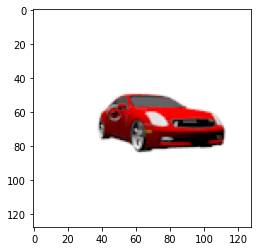

In [85]:
plt.imshow(img)

In [34]:
from torchvision.models import resnet50

In [35]:
model = resnet50(pretrained=True)
fc = model.fc
model.fc=nn.Identity()


In [10]:
# model
tensor_img = img.permute(2,0,1).float()

In [32]:
with torch.no_grad():
    model(external_dataset[0][0].unsqueeze(0))

NameError: name 'model' is not defined

In [ ]:
print(model)

In [6]:
base_path = f'/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/{dataset}_train_test/'
dst_path=f'/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/{dataset}_pool/'
# os.mkdir(dst_path)

In [7]:
intrins = sorted(
    glob.glob(os.path.join(base_path, "*", "intrinsics.txt"))
)

In [8]:
intrins[0]

'/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/chairs_train_test/1007e20d5e811b308351982a6e40cf41/intrinsics.txt'

In [90]:
idx=0

for intrin_path in tqdm(intrins[:]):
    dir_path = os.path.dirname(intrin_path)
    uid = dir_path.split('/')[-1]
    rgb_paths = sorted(glob.glob(os.path.join(dir_path, "rgb", "*.png")))
    rand_idx = random.choices(list(range(len(rgb_paths))), k=25)
    select_rgbs = [rgb_paths[i] for i in rand_idx]
    
    Path(dst_path + '/{}'.format(uid)).mkdir(parents=True, exist_ok=True)
    
    for rgb_path in select_rgbs:
        
        shutil.copy(rgb_path, dst_path+'{}/{:07}.png'.format(uid, idx))
        idx+=1
    

100%|██████████| 2151/2151 [11:27<00:00,  3.13it/s]


In [23]:
from torchvision import datasets, transforms

dst_path_v0='/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/{}_pool/'.format(dataset)

data_transform = transforms.Compose(
    [
#         transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.9084, 0.9045, 0.9019], std=[0.2319, 0.2415, 0.2483] # chairs
#             mean = [0.9052, 0.8945, 0.8894], std=[0.2232, 0.2390, 0.2472] # cars
        ),
    ]
)

external_dataset = datasets.ImageFolder(root=dst_path, transform=data_transform)
len(external_dataset)

115300

In [52]:
l2norm = Normalize(2)

for idx in range(10):
    train_instance=train_set[idx]
    imgs = train_instance['images'].permute(0,3,1,2).float()
    norm_imgs = data_transform(imgs)

    with torch.no_grad():
        feats = l2norm(model(norm_imgs))
        
    torch.save(feats, Path(train_instance['path']) / 'feats.pt')

In [72]:
id0_feats = torch.load(Path(train_set[0]['path']) / 'feats.pt')
d_path = Path(f'/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/{dataset}_pool_sub/{dsize}')
mb_chairs = torch.load(d_path / 'memory_bank.pt')

In [73]:
mb_chairs.shape

torch.Size([10000, 2048])

In [107]:
dataset_loader = torch.utils.data.DataLoader(external_dataset, batch_size=32, shuffle=False, num_workers=4)

In [108]:
# from util.util import calculate_mean_std
mean, std = calculate_mean_std(dataset_loader)

In [54]:
# external_dataset

In [110]:
memory_bank = torch.zeros(len(external_dataset), 2048)

In [ ]:
idx=0
labels = np.zeros((len(external_dataset)))
l2norm = Normalize(2)
with torch.no_grad():
    for data in tqdm(dataset_loader):
        data, label = data
#         out = model(data)
#         out = l2norm(out)
# #         ipdb.set_trace()
#         memory_bank[idx:idx+data.size(0)] = out
        labels[idx:idx+data.size(0)]=label
        idx += data.size(0)
        

In [70]:
torch.save(memory_bank, '/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/{}_pool_memory_bank.pt'.format(dataset))

NameError: name 'memory_bank' is not defined

In [139]:
from torchvision.datasets import CIFAR100, CIFAR10

In [141]:
cifar = CIFAR10(root='~/Dataset/CIFAR10', download=True)

In [153]:
# !wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
# ! pwd

In [156]:
import json

class_idx = json.load(open('imagenet_class_index.json'))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [193]:
idx2label[600]

'hook'

In [209]:
for idx in out[0].sort()[1][-10:]:
    print(idx2label[idx])

Loafer
pencil_sharpener
megalith
vault
monitor


IndexError: list index out of range

# visualization 

In [194]:
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(4, 2)

In [195]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

In [211]:
selected_idices = np.load(f'/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/chairs_pool_sub/10000/idx.npy')

In [61]:
dsize=10000

In [64]:
with open(f'/mnt/lustre/yslan/Repo/NVS/Projects/volume_rendering/srn_dataset/{dataset}_pool_sub/{dsize}/paths.txt', 'r') as f:
    paths = [i.strip() for i in f.readlines()]

In [105]:
emsemble_feat = torch.mean(id0_feats[1:4], 0, keepdim=True)[0]
emsemble_feat.shape

torch.Size([2048])

In [108]:
emsemble_feat.dot(id0_feats[3])

tensor(0.6625)

In [109]:
v = emsemble_feat

In [110]:
sim = mb_chairs @ v

In [111]:
ordered_sim = torch.argsort(sim, descending=True)

In [151]:
sim[ordered_sim]

tensor([0.6897, 0.6890, 0.6887,  ..., 0.6054, 0.6049, 0.5901])

In [231]:
torch.save(ordered_sim, 'debug/ordered_sim_1w.pt')

In [235]:
 f'{1}'+('a' if False else '')

'1'

In [128]:
l = torch.nn.Linear(2,5)

In [134]:
l.weight[:3].requires_grad=False

RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

In [136]:
ckpt = torch.load('./logs/PIXNERF/SRN/Y/Chairs/AE_PT/9views_Y_AE_PT_id0_uniform_1w_pt_newY/099.tar')

In [144]:
# ckpt['encoder'].keys()

# IMAGENET

In [169]:
imgnet_dir=Path('/mnt/lustre/share/images/')

In [154]:
val_txt = Path('/mnt/lustre/share/images/meta/val.txt')

In [156]:
with open(val_txt) as val_f:
    val_imgs = [i.strip() for i in val_f.readlines()]

In [170]:
imgnet_val = torchvision.datasets.ImageFolder(imgnet_dir / 'val')

RuntimeError: Found 0 files in subfolders of: /mnt/lustre/share/images/val
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

In [172]:
val_path = imgnet_dir / 'val'
transform = transforms.Compose(
    [transforms.ToTensor()]
)
imagenet_data = torchvision.datasets.ImageFolder(val_path, transform=transform)

data_loader = torch.utils.data.DataLoader(
    imagenet_data,
    batch_size=64,
    shuffle=True,
    num_workers=0
)
return data_loader

RuntimeError: Found 0 files in subfolders of: /mnt/lustre/share/images/val
Supported extensions are: .jpg,.jpeg,.png,.ppm,.bmp,.pgm,.tif,.tiff,.webp

In [ ]:
idx=0
labels = np.zeros((len(external_dataset)))
l2norm = Normalize(2)
with torch.no_grad():
    for data in tqdm(dataset_loader):
        data, label = data
#         out = model(data)
#         out = l2norm(out)
# #         ipdb.set_trace()
#         memory_bank[idx:idx+data.size(0)] = out
        labels[idx:idx+data.size(0)]=label
        idx += data.size(0)
        

In [174]:
list(map(torch.Tensor.item, [torch.Tensor([5])]))

[5.0]

In [175]:
!nvidia-smi

Sun Jan 31 16:51:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   32C    P0    36W / 250W |   1456MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   29C    P0    25W / 250W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T